In [1]:
import multipers as mp
import multipers.ml.multi as mmm
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt

# Multiparameter persistence introduction

## Point clouds

### Robustness to noise

Let's start with a standard annulus. Adding a diffuse noise on a point cloud is known to be notoriously unstable w.r.t. persistence diagrams. We sampled here `1000` points on an annulus, aswell as `500` points on the square.

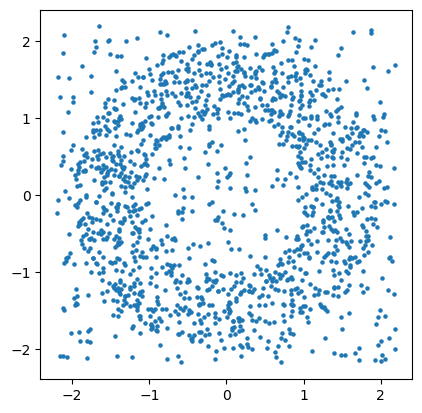

In [2]:
X = mp.noisy_annulus(n1=1000, n2=500)
plt.scatter(X[:,0], X[:,1], s=5); plt.gca().set_aspect(1)

Without any surprise, the barcode associated with standard persistence cannot really retrieve the topology of the annulus

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

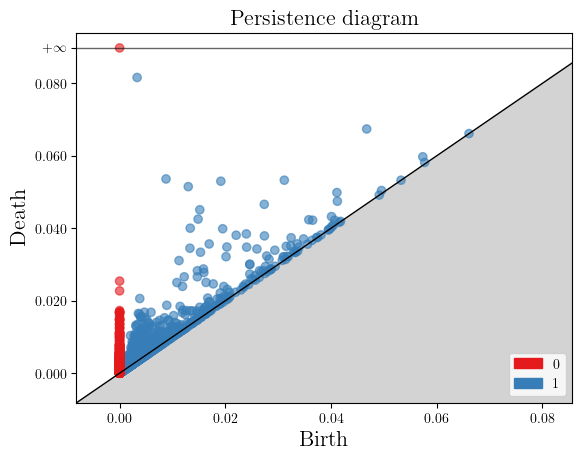

In [3]:
persistence = gd.AlphaComplex(points=X).create_simplex_tree().persistence()
gd.plot_persistence_diagram(persistence)

One way to deal with this issue is to take into account the sampling measure of the dataset; it is much more concentrated on the annulus than on the diffuse noise.

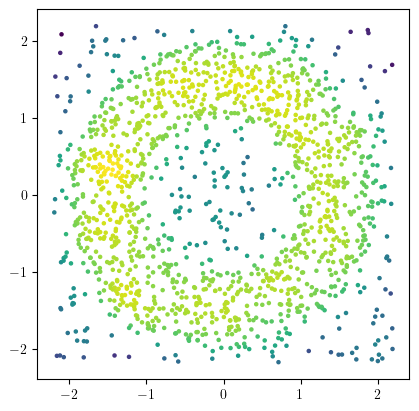

In [4]:
from sklearn.neighbors import KernelDensity
density = KernelDensity(bandwidth=0.2).fit(X).score_samples(X)
plt.scatter(X[:,0], X[:,1], s=5, c=density); plt.gca().set_aspect(1)

We then generate a 2-filtration, with first axis the rips radius, and the second axis given by the codensity, using the `RipsDensity2SimplexTree` pipeline.

In [5]:
from multipers.ml.multi import RipsDensity2SimplexTree
simplextree, = RipsDensity2SimplexTree(bandwidth=0.2, num_collapses="full", sparse=0.3).fit_transform([X])

A representation of the 2 persistence can be computed using interval decomposition technics, such as our `multiparameter_module_approximation` module. Here each interval, i.e., colored shape, visually correspond to the lifetime of a cycle in this 2-filtration. As you can see, there is one significant shape that stands out, which correspond to the annulus.

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


Text(0, 0.5, 'Codensity')

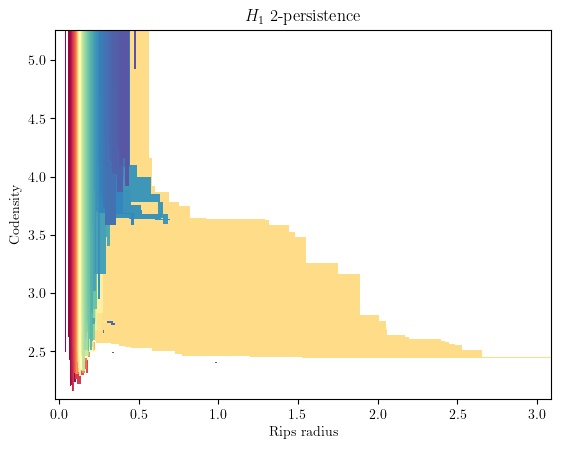

In [6]:
from multipers.ml.multi import SimplexTree2MMA
simplextree.expansion(2)
bimod, = SimplexTree2MMA().fit_transform([simplextree])
bimod.plot(degree=1)
plt.xlabel("Rips radius")
plt.ylabel("Codensity")

Although this structure is more visual, it can still be too expensive to compute depending on the usecase. On that end, the `hilbert signed measure` is another topological invariant, derived from the dimension vector of this 2-parameter module, which can be significantly faster to compute, depending on the parameters. In the following figure, each blue dot correspond to a *birthtime* and each red dot correspond to a *deathtime* in this 2-filtration.

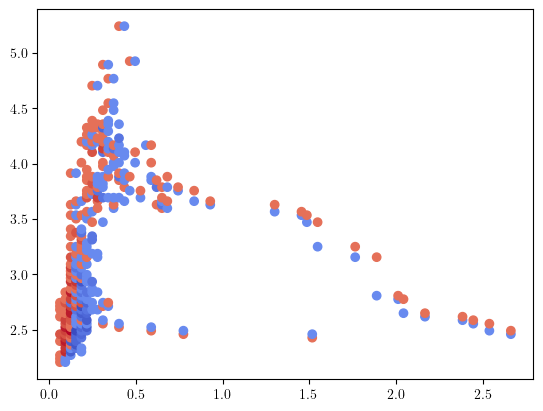

In [7]:
from multipers.ml.multi import SimplexTree2SignedMeasure
sm, = SimplexTree2SignedMeasure(degrees=[1], plot=True, enforce_null_mass=False).fit_transform([simplextree])

Signed measures can also be computed from different topological invariant derived from a $n$-parameter persistence module, e.g., the *Euler characteristic*, which leads to the *Euler signed masure*. This one can be very fast to compute, but is not well suited to be used on point clouds, as it has to be computed on the full simplicial complex, i.e., using the simplices of all dimension, which can be prohibitive to store.

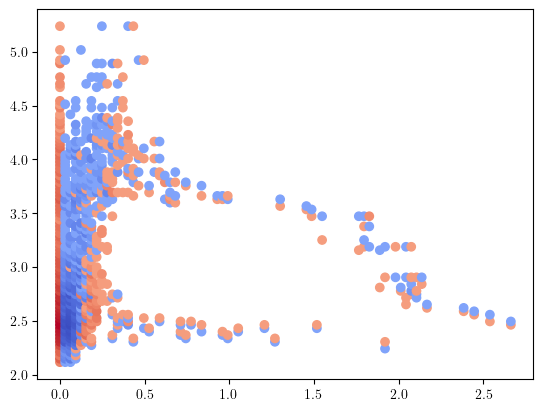

In [8]:
from multipers.ml.multi import SimplexTree2SignedMeasure
sm, = SimplexTree2SignedMeasure(degrees=[None], plot=True, enforce_null_mass=False).fit_transform([simplextree])

### Taking into account the concentration of the sampling

We consider the same strategy as above but with another dataset. We will see that we are able to use the concentration of the sampling measure to our adventage.

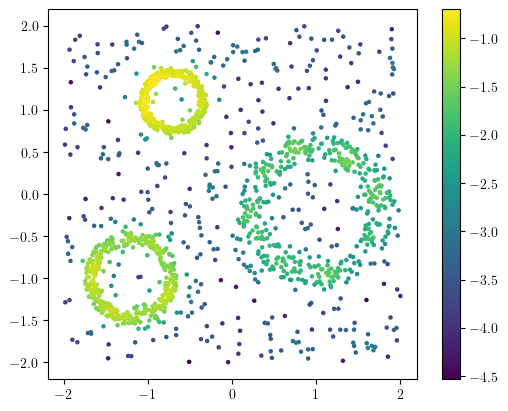

In [9]:
n_pts = 1000
n_outliers = 500 
X = np.block([
    [np.random.uniform(low=-2,high=2,size=(n_outliers,2))],
    [np.array(mp.noisy_annulus(0.6,0.9,(int)(n_pts*1/3), 0, center = [1,-0.2]))],
    [np.array(mp.noisy_annulus(0.4,0.55,(int)(n_pts*1/3), 0, center = [-1.2,-1]))],
    [np.array(mp.noisy_annulus(0.3,0.4,(int)(n_pts*1/3), 0, center = [-0.7,1.1]))],
])
from sklearn.neighbors import KernelDensity
density = KernelDensity(bandwidth=0.1).fit(X).score_samples(X)
plt.scatter(X[:,0], X[:,1],s=5, c = density)
plt.gca().set_aspect(1); plt.colorbar()

As expected, we can clearly distinguish the 3 circles as the 3 big shapes in the figure below, and identify them using their radii. The surprising part is that multiparameter persistence also allows us to identify them using the **concentration** of their sampling ! This allows to retrieve much more information from the dataset :)

/Users/dloiseau/micromamba/envs/python/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


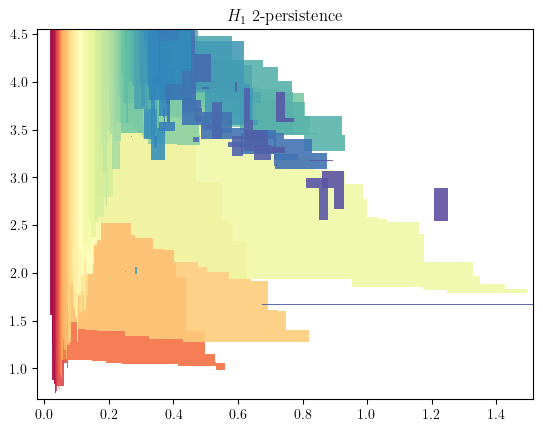

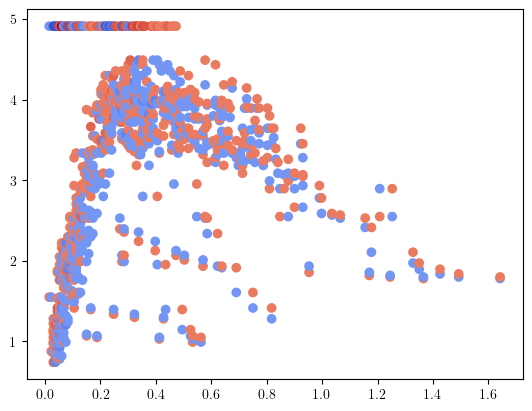

In [10]:
st = mmm.RipsDensity2SimplexTree(expand_dim=2, bandwidth=0.1,num_collapses="full", sparse=0.3, threshold=1.5).fit_transform([X])
mod, = mmm.SimplexTree2MMA().fit_transform(st)
mod.plot(1, alpha=0.9)
plt.show()
sm = mmm.SimplexTree2SignedMeasure(degrees=[1],plot=True, resolution=200).fit_transform(st)

Note that signed measures can be easily turned into vectors using convolutions, via e.g., the `SignedMeasure2Convolution` class.

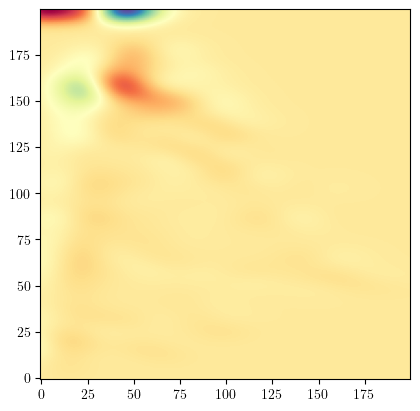

In [11]:
img, = mmm.SignedMeasure2Convolution(
    resolution=200, 
    infer_grid_strategy="regular",
    bandwidth=.1,
).fit_transform(sm)

plt.imshow(img.T, origin="lower", cmap="Spectral")

## Adding more parameters

### Graph classification

Some dataset comes with intrinsic values that can be used as filtrations, e.g., graphs, medical images, molecules. Multiparameter persistence is then very well suited to deal will all of this information **at once**. To bring this to light, we will consider the BZR graph dataset. It can be found [here](https://networkrepository.com/BZR.php).

In [12]:
import multipers.data.graphs as mdg
import networkx as nx
from random import choice
dataset="graphs/BZR"
path = mdg.DATASET_PATH+dataset
!ls $path ## We assume that the dataset is in this folder. You can modify the variable `mdg.DATASET_PATH` if necessary

BZR.edges        BZR.node_attrs   graphs.pkl       readme.html
BZR.graph_idx    BZR.node_labels  labels.pkl
BZR.graph_labels BZR.readme       mat


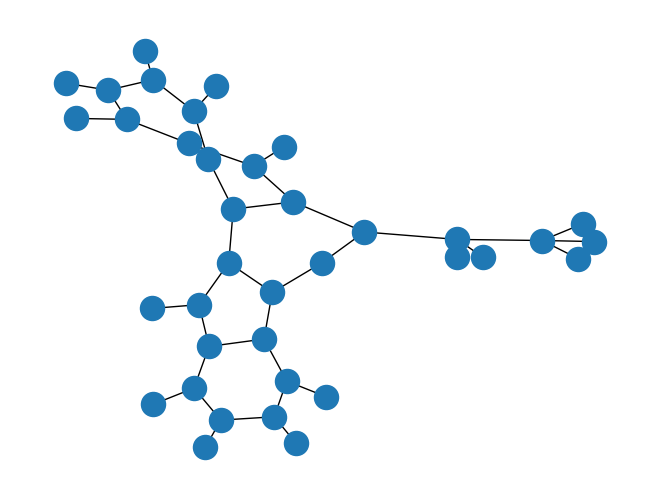

In [13]:
graphs, labels = mdg.get_graphs(dataset)
nx.draw(choice(graphs))

Graph dataset can be filtered by several filtration : node degrees, intrinsic values, ricci curvature, closeness centrality, heat kernel signature, etc.

In [14]:
# mdg.compute_filtration(dataset, filtration="ALL") ## Computes all implemented filtrations for this dataset and stores them in a file
graphs, labels = mdg.get_graphs(dataset) # Retrieves these filtrations
g = graphs[0] # First graph of the dataset
g.nodes[0] # First node of the dataset, which holds several filtrations

{'intrinsic': array([-2.626347,  2.492403,  0.061623]),
 'geodesic': 0,
 'cc': 0.2116788321167883,
 'degree': 0.3333333333333333,
 'ricciCurvature': -0.11111111111111105,
 'fiedler': 0.03371259809689128,
 'hks_10': 0.13721841042259458}

Similarly to the point clouds, we can create simplextrees, and turn them into signed measures

In [15]:
simplextrees = mdg.Graph2SimplexTree(filtrations=["hks_10","degree","geodesic", "cc"]).fit_transform(graphs)

Computing simplextrees from graphs: 100%|██████████| 405/405 [00:00<00:00, 5089.46it/s]


In [16]:
import multipers.ml.multi as mmm
signed_measures = mmm.SimplexTree2SignedMeasure(degrees=[None], n_jobs=-1).fit_transform(simplextrees) # None correspond to the euler characteristic, which is significantly faster to compute on graphs. 
# One may want to rescale filtrations w.r.t. each other. This can be done using the SignedMeasureFormatter class
signed_measures = mmm.SignedMeasureFormatter(normalize=True).fit_transform(signed_measures)

And finally classify these graphs using either a sliced wasserstein kernel, or a convolution.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from multipers.ml.kernels import DistanceMatrix2Kernel
## Split the data into train test
xtrain,xtest,ytrain,ytest = train_test_split(signed_measures, labels)
## Classification pipeline using the sliced wasserstein kernel
classifier = Pipeline([
    ("SWD",mmm.SignedMeasure2SlicedWassersteinDistance(n_jobs=-1)),
    ("KERNEL", DistanceMatrix2Kernel(sigma=1.)),
    ("SVM", SVC(kernel="precomputed")),
])
## Evaluates the classifier on this dataset. 
# Note that there is no cross validation here, so results can be significantly improved
classifier.fit(xtrain,ytrain).score(xtest,ytest)

0.9019607843137255